In [30]:
!pip install pandas scikit-learn transformers nltk gensim spacy matplotlib seaborn wordcloud pyldavis rouge-score sentencepiece
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import re
import joblib
from transformers import T5ForConditionalGeneration, T5Tokenizer, AutoTokenizer, AutoModelForSeq2SeqLM
from rouge_score import rouge_scorer
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
import spacy
import spacy.cli
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Ensure spaCy English model is available
try:
    _ = spacy.load('en_core_web_sm')
except OSError:
    spacy.cli.download('en_core_web_sm')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\panji\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\panji\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\panji\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Task 1: Sentiment Analysis
This section focuses on classifying text into positive or negative sentiment using the IMDb dataset.

In [31]:
# Load and preprocess sentiment analysis data
sa_data = pd.read_csv('../data/imdb-dataset.csv')

# Preprocessing function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

sa_data['cleaned_review'] = sa_data['review'].apply(preprocess_text)

# Split data
X_train_sa, X_test_sa, y_train_sa, y_test_sa = train_test_split(
    sa_data['cleaned_review'], sa_data['sentiment'], test_size=0.2, random_state=42
)

print(sa_data.head())


                                              review sentiment   
0  One of the other reviewers has mentioned that ...  positive  \
1  A wonderful little production. <br /><br />The...  positive   
2  I thought this was a wonderful way to spend ti...  positive   
3  Basically there's a family where a little boy ...  negative   
4  Petter Mattei's "Love in the Time of Money" is...  positive   

                                      cleaned_review  
0  one reviewer mentioned watching oz episode hoo...  
1  wonderful little production filming technique ...  
2  thought wonderful way spend time hot summer we...  
3  basically family little boy jake think zombie ...  
4  petter mattei love time money visually stunnin...  


In [32]:
# Feature engineering and model training for sentiment analysis
vectorizer_sa = TfidfVectorizer(max_features=5000)
X_train_sa_vec = vectorizer_sa.fit_transform(X_train_sa)
X_test_sa_vec = vectorizer_sa.transform(X_test_sa)

model_sa = LogisticRegression()
model_sa.fit(X_train_sa_vec, y_train_sa)


LogisticRegression()

Sentiment Analysis Accuracy: 0.8887
Sentiment Analysis F1-Score: 0.891063913086033


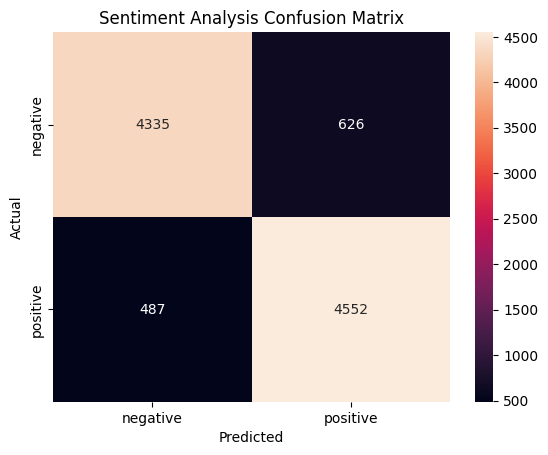

In [33]:
# Evaluate sentiment analysis model
y_pred_sa = model_sa.predict(X_test_sa_vec)
accuracy_sa = accuracy_score(y_test_sa, y_pred_sa)
f1_sa = f1_score(y_test_sa, y_pred_sa, pos_label='positive')

print(f'Sentiment Analysis Accuracy: {accuracy_sa}')
print(f'Sentiment Analysis F1-Score: {f1_sa}')

# Confusion matrix
cm_sa = confusion_matrix(y_test_sa, y_pred_sa)
sns.heatmap(cm_sa, annot=True, fmt='d', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Sentiment Analysis Confusion Matrix')
plt.show()


In [34]:
# Save sentiment analysis model
joblib.dump(model_sa, 'sentiment_analysis_model.pkl')
joblib.dump(vectorizer_sa, 'sentiment_analysis_vectorizer.pkl')


['sentiment_analysis_vectorizer.pkl']

# Task 2: Text Summarization
This section focuses on generating concise summaries from text documents using the CNN/DailyMail dataset.

In [35]:
# Load and preprocess text summarization data
ts_data = pd.read_csv('../data/cnn_dailymail.csv')

# Initialize model and tokenizer (robust to backend availability)
model_name = 't5-small'
model_ts = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer_ts = AutoTokenizer.from_pretrained(model_name)

# Select a sample to summarize
article = ts_data['article'].iloc[0]
reference_summary = ts_data['summary'].iloc[0]
print('Loaded article & reference summary sample.')


C:\Users\panji\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded article & reference summary sample.


In [36]:
# Generate summary
prefix = 'summarize: ' if getattr(model_ts.config, 'model_type', '') == 't5' else ''
inputs = tokenizer_ts.encode(prefix + article, return_tensors="pt", max_length=512, truncation=True)
outputs = model_ts.generate(
    inputs,
    max_length=150,
    min_length=40,
    length_penalty=2.0,
    num_beams=4,
    early_stopping=True
)
generated_summary = tokenizer_ts.decode(outputs[0], skip_special_tokens=True)

print("Original Article:\n", article[:1000], '...')
print("\nReference Summary:\n", reference_summary)
print("\nGenerated Summary:\n", generated_summary)


Original Article:
 london england reuters harry potter star daniel radcliffe gains access reported million million fortune turns monday insists money wont cast spell daniel radcliffe harry potter harry potter order phoenix disappointment gossip columnists around world young actor says plans fritter cash away fast cars drink celebrity parties dont plan one people soon turn suddenly buy massive sports car collection something similar told australian interviewer earlier month dont think ill particularly extravagant things like buying things cost pounds books cds dvds radcliffe able gamble casino buy drink pub see horror film hostel part ii currently six places number one movie uk box office chart details hell mark landmark birthday wraps agent publicist comment plans ill definitely sort party said interview hopefully none reading radcliffes earnings first five potter films held trust fund able touch despite growing fame riches actor says keeping feet firmly ground people always looking sa

In [37]:
# Evaluate text summarization model
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
scores = scorer.score(reference_summary, generated_summary)

print("\nROUGE Scores:", scores)



ROUGE Scores: {'rouge1': Score(precision=0.22666666666666666, recall=0.68, fmeasure=0.34), 'rouge2': Score(precision=0.16216216216216217, recall=0.5, fmeasure=0.2448979591836735), 'rougeL': Score(precision=0.2, recall=0.6, fmeasure=0.3)}


In [38]:
# Save text summarization model
model_ts.save_pretrained('./t5_summarization_model')
tokenizer_ts.save_pretrained('./t5_summarization_model')


('./t5_summarization_model\\tokenizer_config.json',
 './t5_summarization_model\\special_tokens_map.json',
 './t5_summarization_model\\tokenizer.json')

# Task 3: Topic Modeling
This section focuses on extracting and visualizing dominant themes/topics from the BBC News dataset.

In [39]:
# Load and preprocess topic modeling data
tm_data = pd.read_csv('../data/bbc-text.csv')

# Preprocessing for topic modeling
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def preprocess_tm(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

tm_data['processed_text'] = tm_data['text'].apply(preprocess_tm)


In [40]:
# Create dictionary and corpus for topic modeling
dictionary_tm = Dictionary(tm_data['processed_text'])
corpus_tm = [dictionary_tm.doc2bow(text) for text in tm_data['processed_text']]

# Train LDA model
lda_model = LdaModel(
    corpus=corpus_tm,
    id2word=dictionary_tm,
    num_topics=5,
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)


In [41]:
# Evaluate and visualize topics
coherence_model_lda = CoherenceModel(model=lda_model, texts=tm_data['processed_text'], dictionary=dictionary_tm, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Coherence Score: {coherence_lda}')

# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus_tm, dictionary_tm)
vis


Coherence Score: 0.4845443225406519


C:\Users\panji\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\dtypes\cast.py:1429: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.068015  0.115490       1        1  38.270567
1      0.049119  0.147877       2        1  19.382061
2     -0.091145  0.003391       3        1  17.357601
4     -0.137121 -0.173916       4        1  14.140277
0      0.247163 -0.092842       5        1  10.849493, topic_info=        Term          Freq         Total Category  logprob  loglift
0             51874.000000  51874.000000  Default  30.0000  30.0000
582     film   1221.000000   1221.000000  Default  29.0000  29.0000
230        $   1341.000000   1341.000000  Default  28.0000  28.0000
137       mr   2904.000000   2904.000000  Default  27.0000  27.0000
179        s   8668.000000   8668.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
852  british    198.276792    583.074919   Topic5  -5.6754   1.1424
1               328.051884   4990.907817   Topic5  -5.1719  -0.5011
213       uk    228.740016   1186.812490   Topic5  -5.5325   0.5746
140      new    233.741854   1955.851107   Topic5  -5.5109   0.0967
171   record    171.245081    659.604475   Topic5  -5.8220   0.8725

[339 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         1  0.440098       
0         2  0.204878       
0         3  0.147123       
0         4  0.110516       
0         5  0.097388       
...     ...       ...    ...
228       5  0.168324   year
4099      3  0.991100  yukos
333       1  0.316469      £
333       3  0.029715      £
333       4  0.653739      £

[538 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 5, 1])

In [42]:
# Save topic model
lda_model.save('topic_modeling_model.model')
dictionary_tm.save('topic_modeling_dictionary.dict')


In [43]:
# Quick Test Harness: Validate saved models end-to-end
import os
import joblib
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import spacy, spacy.cli


def ensure_spacy():
    try:
        return spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    except OSError:
        spacy.cli.download('en_core_web_sm')
        return spacy.load('en_core_web_sm', disable=['parser', 'ner'])


def preprocess_tm_text(text, nlp=None):
    nlp = nlp or ensure_spacy()
    doc = nlp(text)
    return [t.lemma_ for t in doc if not t.is_stop and not t.is_punct]


def test_sentiment(text: str):
    try:
        vec = joblib.load('sentiment_analysis_vectorizer.pkl')
        clf = joblib.load('sentiment_analysis_model.pkl')
    except Exception as e:
        print('Sentiment model/vectorizer not found. Run the Sentiment Analysis training cells first.')
        print('Error:', e)
        return
    pred = clf.predict(vec.transform([text]))[0]
    print(f"Sentiment prediction: {pred} | Text: {text}")


def test_summarize(text: str, model_dir: str = './t5_summarization_model', fallback_model: str = 't5-small'):
    try:
        tok = AutoTokenizer.from_pretrained(model_dir)
        mdl = AutoModelForSeq2SeqLM.from_pretrained(model_dir)
    except Exception:
        # Fallback to downloading a base model if local dir missing
        tok = AutoTokenizer.from_pretrained(fallback_model)
        mdl = AutoModelForSeq2SeqLM.from_pretrained(fallback_model)
    prefix = 'summarize: ' if getattr(mdl.config, 'model_type', '') == 't5' else ''
    inputs = tok.encode(prefix + text, return_tensors='pt', max_length=512, truncation=True)
    outputs = mdl.generate(inputs, max_length=120, min_length=30, num_beams=4, length_penalty=2.0, early_stopping=True)
    summ = tok.decode(outputs[0], skip_special_tokens=True)
    print('Summary:', summ)


def test_topics(text: str):
    try:
        dictionary = Dictionary.load('topic_modeling_dictionary.dict')
        lda = LdaModel.load('topic_modeling_model.model')
    except Exception as e:
        print('Topic model/dictionary not found. Run the Topic Modeling training cells first.')
        print('Error:', e)
        return
    tokens = preprocess_tm_text(text)
    bow = dictionary.doc2bow(tokens)
    topics = sorted(lda.get_document_topics(bow), key=lambda x: x[1], reverse=True)
    print('Top topics (topic_id, probability):', topics[:3])
    if topics:
        print('Top topic terms:', lda.print_topic(topics[0][0]))


print('--- Quick test: Sentiment ---')
test_sentiment('I loved this movie; it was fantastic and heartwarming.')
test_sentiment('This film was terrible, boring, and a complete waste of time.')

print('\n--- Quick test: Summarization ---')
test_summarize('The city council approved a new public transportation plan aimed at reducing traffic congestion. It includes expanded bus routes, dedicated bike lanes, and subsidies for electric vehicles to encourage greener commuting options. The plan is expected to roll out over the next two years, starting with a pilot program in the downtown area.')

print('\n--- Quick test: Topic Modeling ---')
test_topics('The prime minister announced new economic measures focusing on inflation control, interest rates, and fiscal policy to stabilize the market.')


--- Quick test: Sentiment ---
Sentiment prediction: positive | Text: I loved this movie; it was fantastic and heartwarming.
Sentiment prediction: negative | Text: This film was terrible, boring, and a complete waste of time.

--- Quick test: Summarization ---
Summary: the city council approved a new public transportation plan. it includes expanded bus routes, dedicated bike lanes, and subsidies for electric vehicles. the plan is expected to roll out over the next two years.

--- Quick test: Topic Modeling ---
Summary: the city council approved a new public transportation plan. it includes expanded bus routes, dedicated bike lanes, and subsidies for electric vehicles. the plan is expected to roll out over the next two years.

--- Quick test: Topic Modeling ---
Top topics (topic_id, probability): [(4, 0.5763518), (3, 0.39287394), (1, 0.012912595)]
Top topic terms: 0.076*" " + 0.018*"s" + 0.017*"$" + 0.013*"say" + 0.013*"year" + 0.012*"£" + 0.011*"sale" + 0.009*"m" + 0.009*"rise" + 0.008*